In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import AdamW
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.metrics import log_loss
from keras.applications import EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


C:\Users\dogot\OneDrive\Documents\python_projects\Netology\computer_vision\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 98s 15s/step - accuracy: 0.5042 - loss: 0.8745 - val_accuracy: 1.0000 - val_loss: 0.6837
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.5271 - loss: 0.9279 - val_accuracy: 1.0000 - val_loss: 0.6611
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - accuracy: 0.4656 - loss: 0.9102 - val_accuracy: 1.0000 - val_loss: 0.6651
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.5578 - loss: 0.8713 - val_accuracy: 1.0000 - val_loss: 0.6638
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 10s/step - accuracy: 0.4240 - loss: 0.9202 - val_accuracy: 1.0000 - val_loss: 0.6691
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.4698 - loss: 0.9452 - val_accuracy: 1.0000 - val_loss: 0.6688
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - accuracy: 0.4427 - loss: 0.9938 - val_accuracy: 1.0000 - val_loss: 0.6677
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.6047 - loss: 0.8178 - val_accuracy: 1.0000 - val_loss: 0.6621
Epoch 

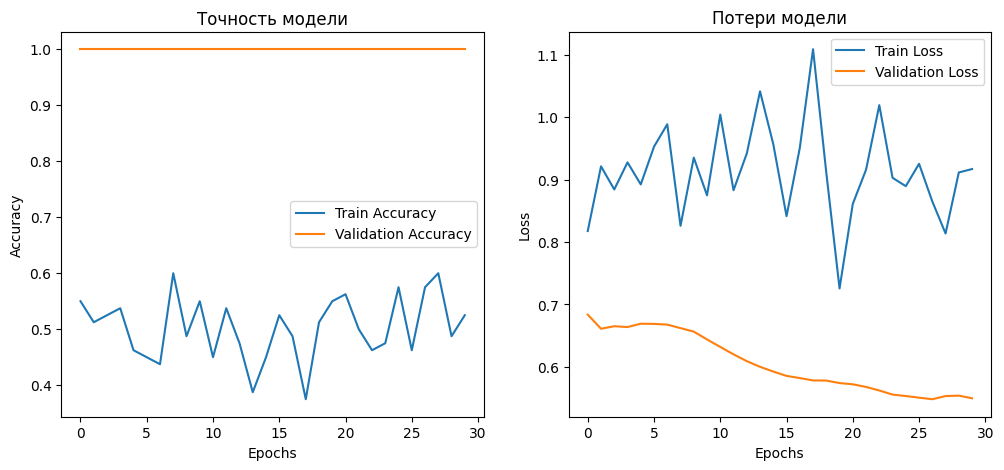

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Log Loss модели: 0.6578
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Кошка 🐱


In [ ]:
# Пути к данным
train_dir = "data/train_sample"
val_dir = "data/test_sample"

# Получаем список всех изображений
train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.endswith(('.jpg', '.png'))]
val_images = [os.path.join(val_dir, img) for img in os.listdir(val_dir) if img.endswith(('.jpg', '.png'))]

# Проверяем наличие изображений
assert len(train_images) > 0, "Ошибка: нет изображений в train_sample"
assert len(val_images) > 0, "Ошибка: нет изображений в test_sample"

# Функция загрузки изображений и меток
def load_images(image_paths):
    images, labels = [], []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Предупреждение: изображение {img_path} не загружено")
            continue
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        images.append(img)

        label = 1 if "dog" in img_path.lower() else 0
        labels.append(label)

    return np.array(images), np.array(labels)

# Загружаем данные
X_train, y_train = load_images(train_images)
X_val, y_val = load_images(val_images)

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Используем предобученную EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

# Замораживаем первые 5 слоев
for layer in base_model.layers[:5]:
    layer.trainable = False

# Создание модели
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='swish'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Компиляция модели с BinaryCrossentropy
model.compile(optimizer=AdamW(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Обучение модели
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_val, y_val))

# Визуализация результатов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Точность модели')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Потери модели')

plt.show()

# Сохранение модели
model.save('cats_vs_dogs_efficientnet.keras')

# Проверка Log Loss
y_pred = model.predict(X_test)
logloss = log_loss(y_test, y_pred)
print(f"Log Loss модели: {logloss:.4f}")

# Функция предсказания
def predict_image(img_path, model):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Ошибка: изображение {img_path} не найдено.")
        return "Файл не существует ❌"

    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    prediction = model.predict(img_array)
    return "Собака 🐶" if prediction[0] > 0.5 else "Кошка 🐱"

# Пример использования
img_path = "data/test_sample/2285.jpg"
print(predict_image(img_path, model))

In [2]:
import pandas as pd

# Делаем предсказания на тестовом наборе данных
test_pred = model.predict(X_test)

# Преобразуем предсказания в бинарные метки (0 - кошка, 1 - собака)
test_pred_labels = (test_pred > 0.5).astype(int).flatten()

# Создаем DataFrame для submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(test_pred_labels) + 1),
    'Label': test_pred_labels
})

# Сохраняем CSV
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Файл сохранен: {submission_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
Файл сохранен: submission.csv
